###Train and test function For varying weight decay values

In [ ]:
import torch.nn as nn
def train0(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
 
def test0(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

###Model 1 with Relu activation function(6 Convolution and 3 fully connected layers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


####Training and Testing on Model 1 with varying weight decay values

In [ ]:
from numpy.random import RandomState
import torch
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# CIFAR-10 data
cifar_train = datasets.CIFAR10(root='.', train=True, transform=train_transform, download=True)
cifar_val = datasets.CIFAR10(root='.', train=True, transform=val_transform, download=True)

# Ensemble learning
num_models = 25
accs = []

weight_decay_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]

for weight_decay in weight_decay_list:
    print(weight_decay)
    for seed in range(num_models):
        print(f"Iteration: {seed}")
        prng = RandomState(seed)
        random_permute = prng.permutation(np.arange(0, 1000))
        classes = prng.permutation(np.arange(0, 10))
        indx_train = np.concatenate([np.where(np.array(cifar_train.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
        indx_val = np.concatenate([np.where(np.array(cifar_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

        train_data = Subset(cifar_train, indx_train)
        val_data = Subset(cifar_val, indx_val)

        print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

        model = Net()
        model.to(device)

        # Learning rate scheduling
        optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

        for epoch in range(100):
            train0(model, device, train_loader, optimizer, epoch, display=epoch % 5 == 0)
            scheduler.step()

        accs.append(test0(model, device, val_loader))

accs = np.array(accs)
print(f"For weight decay: {weight_decay}")
print('Acc over %d instances: \n%s'%(num_models, accs.reshape(len(weight_decay_list), num_models)))
print('Mean Acc: \n%s'%(np.mean(accs.reshape(len(weight_decay_list), num_models), axis=1)))
print('Std Deviation: \n%s'%(np.std(accs.reshape(len(weight_decay_list), num_models), axis=1)))


Files already downloaded and verified
Files already downloaded and verified
0.0001
Iteration: 0
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.168865
Train Epoch: 5 [0/50 (0%)]	Loss: 0.412498
Train Epoch: 10 [0/50 (0%)]	Loss: 0.024760
Train Epoch: 15 [0/50 (0%)]	Loss: 0.021354
Train Epoch: 20 [0/50 (0%)]	Loss: 0.019225
Train Epoch: 25 [0/50 (0%)]	Loss: 0.008146
Train Epoch: 30 [0/50 (0%)]	Loss: 0.004207
Train Epoch: 35 [0/50 (0%)]	Loss: 0.002479
Train Epoch: 40 [0/50 (0%)]	Loss: 0.002864
Train Epoch: 45 [0/50 (0%)]	Loss: 0.002840
Train Epoch: 50 [0/50 (0%)]	Loss: 0.002771
Train Epoch: 55 [0/50 (0%)]	Loss: 0.002301
Train Epoch: 60 [0/50 (0%)]	Loss: 0.002712
Train Epoch: 65 [0/50 (0%)]	Loss: 0.002618
Train Epoch: 70 [0/50 (0%)]	Loss: 0.003522
Train Epoch: 75 [0/50 (0%)]	Loss: 0.002724
Train Epoch: 80 [0/50 (0%)]	Loss: 0.002494
Train Epoch: 85 [0/50 (0%)]	Loss: 0.001942
Train Epoch: 90 [0/50 (0%)]	Loss: 0.002353
Train Epoch: 95 [0/50 (0%)]	Loss: 0.0

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6651, Accuracy: 327/400 (81.75%)

Iteration: 1
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.190813
Train Epoch: 5 [0/50 (0%)]	Loss: 0.831390
Train Epoch: 10 [0/50 (0%)]	Loss: 0.357889
Train Epoch: 15 [0/50 (0%)]	Loss: 0.089572
Train Epoch: 20 [0/50 (0%)]	Loss: 0.097706
Train Epoch: 25 [0/50 (0%)]	Loss: 0.019235
Train Epoch: 30 [0/50 (0%)]	Loss: 0.013212
Train Epoch: 35 [0/50 (0%)]	Loss: 0.008602
Train Epoch: 40 [0/50 (0%)]	Loss: 0.007200
Train Epoch: 45 [0/50 (0%)]	Loss: 0.006388
Train Epoch: 50 [0/50 (0%)]	Loss: 0.004332
Train Epoch: 55 [0/50 (0%)]	Loss: 0.004652
Train Epoch: 60 [0/50 (0%)]	Loss: 0.007102
Train Epoch: 65 [0/50 (0%)]	Loss: 0.003807
Train Epoch: 70 [0/50 (0%)]	Loss: 0.004071
Train Epoch: 75 [0/50 (0%)]	Loss: 0.003980
Train Epoch: 80 [0/50 (0%)]	Loss: 0.008494
Train Epoch: 85 [0/50 (0%)]	Loss: 0.005496
Train Epoch: 90 [0/50 (0%)]	Loss: 0.009190
Train Epoch: 95 [0/50 (0%)]	Loss: 0.004650

Test set: Avera

KeyboardInterrupt: ignored

###Model 2 with Drop block added (6 Convolutional layers and 3 fully connected layers)

In [ ]:
import torch
print(torch.__version__)

2.0.0+cu118


In [ ]:
pip install dropblock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dropblock

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import DropBlock2d
from torchvision.ops import drop_block2d
import matplotlib.pyplot as plt
class Net_Dropblock(nn.Module):
    def __init__(self):
        super(Net_Dropblock, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
        # DropBlock2D layer added to the model
        self.dropblock = dropblock.DropBlock2D(block_size=2, drop_prob=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropblock(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropblock(F.relu(self.bn5(self.conv5(x))))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing Model 2

Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.488380
Train Epoch: 5 [0/50 (0%)]	Loss: 0.027111
Train Epoch: 10 [0/50 (0%)]	Loss: 0.001957
Train Epoch: 15 [0/50 (0%)]	Loss: 0.003589
Train Epoch: 20 [0/50 (0%)]	Loss: 0.001545
Train Epoch: 25 [0/50 (0%)]	Loss: 0.000346
Train Epoch: 30 [0/50 (0%)]	Loss: 0.000224
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000102
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000030
Train Epoch: 45 [0/50 (0%)]	Loss: 0.001102
Train Epoch: 50 [0/50 (0%)]	Loss: 0.000031
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000018
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000049
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000022
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000010
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000018
Train Epoch: 80 [0/50 (0%)]	Loss: 0.000169
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000015
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000056
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000015

Test set: Ave

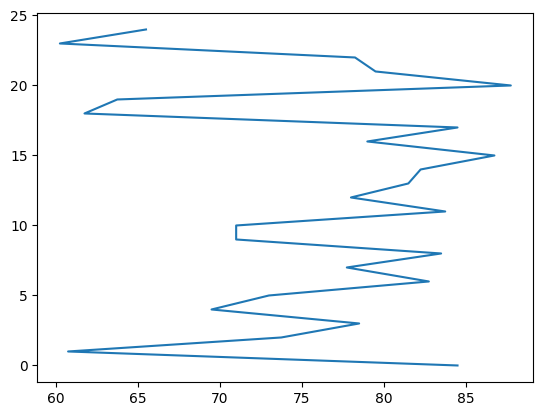

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []
seeds=[]

for seed in range(25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net_Dropblock()
  model.to(device)
  # for name, param in model.named_parameters():
    # print(f"{name}: {param.size()}")
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.001)
  for epoch in range(100):
    train0(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test0(model, device, val_loader))
  seeds.append(seed)
accs = np.array(accs)


Acc over 25 instances: 75.94 +- 8.29


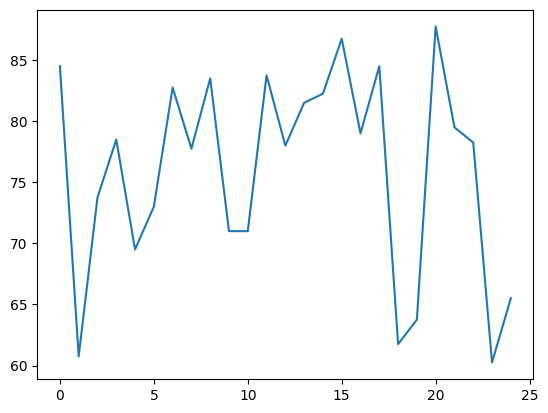

In [ ]:
print('Acc over 25 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))
plt.plot(seeds,accs)
plt.show()

### Model 2 but instead of DropBlock we add Dropout 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import DropBlock2d
from torchvision.ops import drop_block2d

class Net_Dropout(nn.Module):
    def __init__(self):
        super(Net_Dropout, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
        # Dropout layer added to the model
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.bn5(self.conv5(x))))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing on Model 2 with Dropouts added

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for seed in range(25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net_Dropout()
  model.to(device)
  # for name, param in model.named_parameters():
    # print(f"{name}: {param.size()}")
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.001)
  for epoch in range(100):
    train0(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test0(model, device, val_loader))

accs = np.array(accs)
print('Acc over 5 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.431320
Train Epoch: 5 [0/50 (0%)]	Loss: 0.179064
Train Epoch: 10 [0/50 (0%)]	Loss: 0.033540
Train Epoch: 15 [0/50 (0%)]	Loss: 0.002985
Train Epoch: 20 [0/50 (0%)]	Loss: 0.000820
Train Epoch: 25 [0/50 (0%)]	Loss: 0.001382
Train Epoch: 30 [0/50 (0%)]	Loss: 0.000111
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000034
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000017
Train Epoch: 45 [0/50 (0%)]	Loss: 0.000082
Train Epoch: 50 [0/50 (0%)]	Loss: 0.000173
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000037
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000004
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000152
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000008
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000026
Train Epoch: 80 [0/50 (0%)]	Loss: 0.000005
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000010
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000003
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000004

Test set: Ave

###Since DropBlock gave us better results than dropouts we will try 2 other activations on it 

###Model 2 with SiLU activation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import DropBlock2d
from torchvision.ops import drop_block2d

class Net_Dropblock_Silu(nn.Module):
    def __init__(self):
        super(Net_Dropblock_Silu, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.silu = nn.SiLU()
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
        # DropBlock2D layer added to the model
        self.dropblock = dropblock.DropBlock2D(block_size=2, drop_prob=0.2)

    def forward(self, x):
        x = self.silu(self.bn1(self.conv1(x)))
        x = self.silu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropblock(self.silu(self.bn3(self.conv3(x))))
        x = self.silu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropblock(self.silu(self.bn5(self.conv5(x))))
        x = self.silu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.silu(self.bn7(self.fc1(x)))
        x = self.silu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing on Model 2 with SiLU activation

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for seed in range(25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net_Dropblock_Silu()
  model.to(device)
  # for name, param in model.named_parameters():
    # print(f"{name}: {param.size()}")
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.001)
  for epoch in range(100):
    train0(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test0(model, device, val_loader))

accs = np.array(accs)
print('Acc over 25 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.517749
Train Epoch: 5 [0/50 (0%)]	Loss: 0.030861
Train Epoch: 10 [0/50 (0%)]	Loss: 0.005270
Train Epoch: 15 [0/50 (0%)]	Loss: 0.000493
Train Epoch: 20 [0/50 (0%)]	Loss: 0.000301
Train Epoch: 25 [0/50 (0%)]	Loss: 0.000022
Train Epoch: 30 [0/50 (0%)]	Loss: 0.000028
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000036
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000048
Train Epoch: 45 [0/50 (0%)]	Loss: 0.000013
Train Epoch: 50 [0/50 (0%)]	Loss: 0.000015
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000235
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000013
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000156
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000022
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000004
Train Epoch: 80 [0/50 (0%)]	Loss: 0.000016
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000002
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000013
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000022


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7968, Accuracy: 340/400 (85.00%)

Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.335001
Train Epoch: 5 [0/50 (0%)]	Loss: 0.058419
Train Epoch: 10 [0/50 (0%)]	Loss: 0.013914
Train Epoch: 15 [0/50 (0%)]	Loss: 0.003672
Train Epoch: 20 [0/50 (0%)]	Loss: 0.001702
Train Epoch: 25 [0/50 (0%)]	Loss: 0.000310
Train Epoch: 30 [0/50 (0%)]	Loss: 0.020469
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000141
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000068
Train Epoch: 45 [0/50 (0%)]	Loss: 0.002136
Train Epoch: 50 [0/50 (0%)]	Loss: 0.002913
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000234
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000252
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000102
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000628
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000050
Train Epoch: 80 [0/50 (0%)]	Loss: 0.000044
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000180
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000148
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000020

Test set: Average loss: 1.96

###Model 2 with Mish activation and DropBlock

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn import DropBlock2d
from torchvision.ops import drop_block2d

class Net_Dropblock_Mish(nn.Module):
    def __init__(self):
        super(Net_Dropblock_Mish, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.mish = nn.Mish()
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
        # DropBlock2D layer added to the model
        self.dropblock = dropblock.DropBlock2D(block_size=2, drop_prob=0.2)

    def forward(self, x):
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropblock(self.mish(self.bn3(self.conv3(x))))
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropblock(self.mish(self.bn5(self.conv5(x))))
        x = self.mish(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.mish(self.bn7(self.fc1(x)))
        x = self.mish(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing on Model 2 with Mish activation and DropBlocks

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for seed in range(25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = Net_Dropblock_Mish()
  model.to(device)
  # for name, param in model.named_parameters():
    # print(f"{name}: {param.size()}")
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.001)
  for epoch in range(100):
    train0(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test0(model, device, val_loader))

accs = np.array(accs)
print('Acc over 25 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.328180
Train Epoch: 5 [0/50 (0%)]	Loss: 0.010042
Train Epoch: 10 [0/50 (0%)]	Loss: 0.004480
Train Epoch: 15 [0/50 (0%)]	Loss: 0.000247
Train Epoch: 20 [0/50 (0%)]	Loss: 0.000220
Train Epoch: 25 [0/50 (0%)]	Loss: 0.000058
Train Epoch: 30 [0/50 (0%)]	Loss: 0.000007
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000604
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000008
Train Epoch: 45 [0/50 (0%)]	Loss: 0.000005
Train Epoch: 50 [0/50 (0%)]	Loss: 0.000020
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000011
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000033
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000004
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000003
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000008
Train Epoch: 80 [0/50 (0%)]	Loss: 0.001376
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000004
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000004
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000005


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.9843, Accuracy: 324/400 (81.00%)

Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 2.299814
Train Epoch: 5 [0/50 (0%)]	Loss: 0.025534
Train Epoch: 10 [0/50 (0%)]	Loss: 0.002666
Train Epoch: 15 [0/50 (0%)]	Loss: 0.001017
Train Epoch: 20 [0/50 (0%)]	Loss: 0.000229
Train Epoch: 25 [0/50 (0%)]	Loss: 0.000156
Train Epoch: 30 [0/50 (0%)]	Loss: 0.000432
Train Epoch: 35 [0/50 (0%)]	Loss: 0.000362
Train Epoch: 40 [0/50 (0%)]	Loss: 0.000166
Train Epoch: 45 [0/50 (0%)]	Loss: 0.000015
Train Epoch: 50 [0/50 (0%)]	Loss: 0.000023
Train Epoch: 55 [0/50 (0%)]	Loss: 0.000329
Train Epoch: 60 [0/50 (0%)]	Loss: 0.000017
Train Epoch: 65 [0/50 (0%)]	Loss: 0.000049
Train Epoch: 70 [0/50 (0%)]	Loss: 0.000037
Train Epoch: 75 [0/50 (0%)]	Loss: 0.000070
Train Epoch: 80 [0/50 (0%)]	Loss: 0.000010
Train Epoch: 85 [0/50 (0%)]	Loss: 0.000014
Train Epoch: 90 [0/50 (0%)]	Loss: 0.000005
Train Epoch: 95 [0/50 (0%)]	Loss: 0.000285

Test set: Average loss: 1.94

#Custom Regularization

###1)Elastic net Regularization

In [ ]:
def custom_loss(y_pred, y_true, model):
    lambda1,lambda2=0.0001,0.0001
    l1_penalty = torch.norm(model.fc1.weight, p=1) + torch.norm(model.fc2.weight, p=1) + torch.norm(model.fc3.weight, p=1)
    l2_penalty = torch.norm(model.fc1.weight, p=2) + torch.norm(model.fc2.weight, p=2) + torch.norm(model.fc3.weight, p=2)
    return F.cross_entropy(y_pred, y_true) + lambda1 * l1_penalty + lambda2 * l2_penalty

###Train and test function with Elastic net regularizer implemented

In [ ]:
import torch.nn as nn
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = custom_loss(output, target, model)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
 
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

###Model 3 with relu activation(6 Convolutional layers and 3 fully connected layers)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# Define the VGG16 model
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x



####Training and Testing on Model 3 with Elastic net Regularization

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset

  
from torchvision import datasets, transforms
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same
transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='.',train=True, transform=transform_train, download=True)
    
#We need two copies of this due to weird dataset api 
cifar_data_val = datasets.CIFAR10(root='.',train=True, transform=transform_val, download=True)
    

accs = []

for seed in range(25):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  classes =  prng.permutation(np.arange(0,10))
  indx_train = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
  indx_val = np.concatenate([np.where(np.array(cifar_data.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])


  train_data = Subset(cifar_data, indx_train)
  val_data = Subset(cifar_data_val, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))
  
  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=128, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                           batch_size=128, 
                                           shuffle=False)
  

  model = VGG16()
  model.to(device)
  # for name, param in model.named_parameters():
    # print(f"{name}: {param.size()}")
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01, momentum=0.9,
                              weight_decay=0.001)
  for epoch in range(100):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
    
  accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over 25 instances: %.2f +- %.2f'%(accs.mean(),accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 28.814293
Train Epoch: 5 [0/50 (0%)]	Loss: 26.211103
Train Epoch: 10 [0/50 (0%)]	Loss: 26.110401
Train Epoch: 15 [0/50 (0%)]	Loss: 25.978876
Train Epoch: 20 [0/50 (0%)]	Loss: 25.828142
Train Epoch: 25 [0/50 (0%)]	Loss: 25.665956
Train Epoch: 30 [0/50 (0%)]	Loss: 25.497200
Train Epoch: 35 [0/50 (0%)]	Loss: 25.324846
Train Epoch: 40 [0/50 (0%)]	Loss: 25.150652
Train Epoch: 45 [0/50 (0%)]	Loss: 24.975636
Train Epoch: 50 [0/50 (0%)]	Loss: 24.800379
Train Epoch: 55 [0/50 (0%)]	Loss: 24.625237
Train Epoch: 60 [0/50 (0%)]	Loss: 24.450422
Train Epoch: 65 [0/50 (0%)]	Loss: 24.276068
Train Epoch: 70 [0/50 (0%)]	Loss: 24.102236
Train Epoch: 75 [0/50 (0%)]	Loss: 23.928970
Train Epoch: 80 [0/50 (0%)]	Loss: 23.756304
Train Epoch: 85 [0/50 (0%)]	Loss: 23.584240
Train Epoch: 90 [0/50 (0%)]	Loss: 23.412796
Train Epoch: 95 [0/50 (0%)]	Loss: 23.2

#2)Max Norm Regularization

###MAX Norm

In [ ]:
import torch
def max_norm_loss(model, max_norm):
    norms = torch.norm(torch.cat([p.flatten() for p in model.parameters()]), p=2, dim=0)
    max_norm_penalty = torch.nn.functional.relu(norms - max_norm)
    return torch.mean(max_norm_penalty)

###MAX NORM Train and test functions

In [ ]:

def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    max_norm = 10.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        compute_loss= nn.functional.cross_entropy(output, target)
        loss = max_norm_loss(model, max_norm)+ compute_loss
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
 
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

###Model 5 with SiLU activation ( 6 Convolution layers and 3 fully connected layers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import drop_block2d

class VGG16_maxnorm(nn.Module):
    def __init__(self):
        super(VGG16_maxnorm, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.silu=nn.SiLU()
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        x = self.silu(self.bn1(self.conv1(x)))
        x = self.silu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.silu(self.bn3(self.conv3(x)))
        x = self.silu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.silu(self.bn5(self.conv5(x)))
        x = self.silu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.silu(self.bn7(self.fc1(x)))
        x = self.silu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x

####Training and Testing on Model 5 with Max Norm Regularization

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# CIFAR-10 data
cifar_train = datasets.CIFAR10(root='.', train=True, transform=train_transform, download=True)
cifar_val = datasets.CIFAR10(root='.', train=True, transform=val_transform, download=True)

# Ensemble learning
num_models = 25
accs = []

for seed in range(25):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes = prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_train.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_train, indx_train)
    val_data = Subset(cifar_val, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = VGG16_maxnorm()
    model.to(device)

    # Learning rate scheduling
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(100):
        train(model, device, train_loader, optimizer, epoch, display=epoch % 5 == 0)
        scheduler.step()

    accs.append(test(model, device, val_loader))

accs = np.array(accs)
print('Acc over %d instances: %.2f +- %.2f'%(num_models, accs.mean(), accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 102.551178
Train Epoch: 5 [0/50 (0%)]	Loss: 100.467888
Train Epoch: 10 [0/50 (0%)]	Loss: 99.676956
Train Epoch: 15 [0/50 (0%)]	Loss: 99.471016
Train Epoch: 20 [0/50 (0%)]	Loss: 99.141571
Train Epoch: 25 [0/50 (0%)]	Loss: 98.881294
Train Epoch: 30 [0/50 (0%)]	Loss: 98.609741
Train Epoch: 35 [0/50 (0%)]	Loss: 98.342506
Train Epoch: 40 [0/50 (0%)]	Loss: 98.072998
Train Epoch: 45 [0/50 (0%)]	Loss: 98.045616
Train Epoch: 50 [0/50 (0%)]	Loss: 98.017960
Train Epoch: 55 [0/50 (0%)]	Loss: 97.988098
Train Epoch: 60 [0/50 (0%)]	Loss: 97.960335
Train Epoch: 65 [0/50 (0%)]	Loss: 97.931870
Train Epoch: 70 [0/50 (0%)]	Loss: 97.902611
Train Epoch: 75 [0/50 (0%)]	Loss: 97.901550
Train Epoch: 80 [0/50 (0%)]	Loss: 97.897255
Train Epoch: 85 [0/50 (0%)]	Loss: 97.895195
Train Epoch: 90 [0/50 (0%)]	Loss: 97.891769
Train Epoch: 95 [0/50 (0%)]	Loss: 97

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7784, Accuracy: 339/400 (84.75%)

Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 102.520607
Train Epoch: 5 [0/50 (0%)]	Loss: 101.357460
Train Epoch: 10 [0/50 (0%)]	Loss: 99.983345
Train Epoch: 15 [0/50 (0%)]	Loss: 99.634384
Train Epoch: 20 [0/50 (0%)]	Loss: 99.261864
Train Epoch: 25 [0/50 (0%)]	Loss: 99.008858
Train Epoch: 30 [0/50 (0%)]	Loss: 98.656075
Train Epoch: 35 [0/50 (0%)]	Loss: 98.381653
Train Epoch: 40 [0/50 (0%)]	Loss: 98.107857
Train Epoch: 45 [0/50 (0%)]	Loss: 98.082375
Train Epoch: 50 [0/50 (0%)]	Loss: 98.056053
Train Epoch: 55 [0/50 (0%)]	Loss: 98.032600
Train Epoch: 60 [0/50 (0%)]	Loss: 98.006279
Train Epoch: 65 [0/50 (0%)]	Loss: 97.973297
Train Epoch: 70 [0/50 (0%)]	Loss: 97.949059
Train Epoch: 75 [0/50 (0%)]	Loss: 97.938568
Train Epoch: 80 [0/50 (0%)]	Loss: 97.940407
Train Epoch: 85 [0/50 (0%)]	Loss: 97.937775
Train Epoch: 90 [0/50 (0%)]	Loss: 97.929848
Train Epoch: 95 [0/50 (0%)]	Loss: 97.929649

Test s

#3)Adversarial Loss Regularization

In [ ]:
def fgsm_attack(model, criterion, x, y, eps=0.1):
    x_adv = x.clone().detach().requires_grad_(True)
    outputs = model(x_adv)
    loss = criterion(outputs, y)
    loss.backward()
    x_adv_grad = x_adv.grad.data
    x_adv = x_adv + eps * torch.sign(x_adv_grad)
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def adversarial_loss(model, criterion, x, y, eps=0.1):
    x_adv = fgsm_attack(model, criterion, x, y, eps)
    outputs = model(x_adv)
    return criterion(outputs, y)


###Train and test function implementing Adversarial loss

In [ ]:

def train1(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    eps = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, target) + adversarial_loss(model, criterion, data, target, eps)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
 
def test1(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.functional.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

###Model 6 with SiLU activation function(6 Convolutional Layers and 3 fully connected layers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import drop_block2d

class NetSilu(nn.Module):
    def __init__(self):
        super(NetSilu, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.silu=nn.SiLU()
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        x = self.silu(self.bn1(self.conv1(x)))
        x = self.silu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.silu(self.bn3(self.conv3(x)))
        x = self.silu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.silu(self.bn5(self.conv5(x)))
        x = self.silu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.silu(self.bn7(self.fc1(x)))
        x = self.silu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and testing on Model 6 with adversarial loss regularization

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# CIFAR-10 data
cifar_train = datasets.CIFAR10(root='.', train=True, transform=train_transform, download=True)
cifar_val = datasets.CIFAR10(root='.', train=True, transform=val_transform, download=True)

# Ensemble learning
num_models = 25
accs = []

for seed in range(25):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes = prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_train.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_train, indx_train)
    val_data = Subset(cifar_val, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = NetSilu()
    model.to(device)

    # Learning rate scheduling
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(100):
        train1(model, device, train_loader, optimizer, epoch, display=epoch % 5 == 0)
        scheduler.step()

    accs.append(test1(model, device, val_loader))

accs = np.array(accs)
print('Acc over %d instances: %.2f +- %.2f'%(num_models, accs.mean(), accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 4.804096
Train Epoch: 5 [0/50 (0%)]	Loss: 2.681089
Train Epoch: 10 [0/50 (0%)]	Loss: 0.195571
Train Epoch: 15 [0/50 (0%)]	Loss: 0.265774
Train Epoch: 20 [0/50 (0%)]	Loss: 0.260262
Train Epoch: 25 [0/50 (0%)]	Loss: 0.204349
Train Epoch: 30 [0/50 (0%)]	Loss: 0.128949
Train Epoch: 35 [0/50 (0%)]	Loss: 0.036974
Train Epoch: 40 [0/50 (0%)]	Loss: 0.091390
Train Epoch: 45 [0/50 (0%)]	Loss: 0.046407
Train Epoch: 50 [0/50 (0%)]	Loss: 0.029783
Train Epoch: 55 [0/50 (0%)]	Loss: 0.037419
Train Epoch: 60 [0/50 (0%)]	Loss: 0.029824
Train Epoch: 65 [0/50 (0%)]	Loss: 0.016472
Train Epoch: 70 [0/50 (0%)]	Loss: 0.054833
Train Epoch: 75 [0/50 (0%)]	Loss: 0.018262
Train Epoch: 80 [0/50 (0%)]	Loss: 0.017192
Train Epoch: 85 [0/50 (0%)]	Loss: 0.020686
Train Epoch: 90 [0/50 (0%)]	Loss: 0.028592
Train Epoch: 95 [0/50 (0%)]	Loss: 0.021909

Test set: Ave

###Model 7  with Mish Activation function and Adversarial loss regularization(6 Convolution layers and 3 fully connected layers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import drop_block2d

class NetMish(nn.Module):
    def __init__(self):
        super(NetMish, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.mish=nn.Mish()
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.mish(self.bn3(self.conv3(x)))
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.mish(self.bn5(self.conv5(x)))
        x = self.mish(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.mish(self.bn7(self.fc1(x)))
        x = self.mish(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing on Model 7 with Adversarial loss regularization


In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# CIFAR-10 data
cifar_train = datasets.CIFAR10(root='.', train=True, transform=train_transform, download=True)
cifar_val = datasets.CIFAR10(root='.', train=True, transform=val_transform, download=True)

# Ensemble learning
num_models = 25
accs = []

for seed in range(25):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes = prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_train.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_train, indx_train)
    val_data = Subset(cifar_val, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = NetMish()
    model.to(device)

    # Learning rate scheduling
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(100):
        train1(model, device, train_loader, optimizer, epoch, display=epoch % 5 == 0)
        scheduler.step()
        accs.append(test1(model, device, val_loader))

accs = np.array(accs)
print('Acc over %d instances: %.2f +- %.2f'%(num_models, accs.mean(), accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 4.943070
Train Epoch: 5 [0/50 (0%)]	Loss: 3.480829
Train Epoch: 10 [0/50 (0%)]	Loss: 0.385605
Train Epoch: 15 [0/50 (0%)]	Loss: 0.306378
Train Epoch: 20 [0/50 (0%)]	Loss: 0.173951
Train Epoch: 25 [0/50 (0%)]	Loss: 0.071787
Train Epoch: 30 [0/50 (0%)]	Loss: 0.074178
Train Epoch: 35 [0/50 (0%)]	Loss: 0.029400
Train Epoch: 40 [0/50 (0%)]	Loss: 0.043658
Train Epoch: 45 [0/50 (0%)]	Loss: 0.035701
Train Epoch: 50 [0/50 (0%)]	Loss: 0.021504
Train Epoch: 55 [0/50 (0%)]	Loss: 0.028569
Train Epoch: 60 [0/50 (0%)]	Loss: 0.029009
Train Epoch: 65 [0/50 (0%)]	Loss: 0.015576
Train Epoch: 70 [0/50 (0%)]	Loss: 0.010340
Train Epoch: 75 [0/50 (0%)]	Loss: 0.048806
Train Epoch: 80 [0/50 (0%)]	Loss: 0.021830
Train Epoch: 85 [0/50 (0%)]	Loss: 0.012381
Train Epoch: 90 [0/50 (0%)]	Loss: 0.031361
Train Epoch: 95 [0/50 (0%)]	Loss: 0.027205

Test set: Ave

###Model 8 with relu activation and dropblock (6 convolutional layers and 3 fully connected layers)

In [ ]:
pip install dropblock

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import dropblock

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.ops import drop_block2d

class Netdropblock(nn.Module):
    def __init__(self):
        super(Netdropblock, self).__init__()
        
        # input size: 3 x 32 x 32
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # size: 64 x 32 x 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 64 x 16 x 16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # size: 128 x 16 x 16
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 128 x 8 x 8
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        
        # size: 256 x 8 x 8
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # size: 256 x 4 x 4
        self.fc1 = nn.Linear(256 * 4 * 4, 4096)
        self.bn7 = nn.BatchNorm1d(4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.bn8 = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)
        
        # DropBlock2D layer added to the model
        self.dropblock = dropblock.DropBlock2D(block_size=2, drop_prob=0.2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropblock(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropblock(F.relu(self.bn5(self.conv5(x))))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x


####Training and Testing on Model 8 with Adversarial Loss regularization

In [ ]:
from numpy.random import RandomState
import numpy as np
import torch.optim as optim
from torch.utils.data import Subset
from torchvision import datasets, transforms

# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# CIFAR-10 data
cifar_train = datasets.CIFAR10(root='.', train=True, transform=train_transform, download=True)
cifar_val = datasets.CIFAR10(root='.', train=True, transform=val_transform, download=True)

# Ensemble learning
num_models = 25
accs = []

for seed in range(25):
    prng = RandomState(seed)
    random_permute = prng.permutation(np.arange(0, 1000))
    classes = prng.permutation(np.arange(0, 10))
    indx_train = np.concatenate([np.where(np.array(cifar_train.targets) == classe)[0][random_permute[0:25]] for classe in classes[0:2]])
    indx_val = np.concatenate([np.where(np.array(cifar_val.targets) == classe)[0][random_permute[25:225]] for classe in classes[0:2]])

    train_data = Subset(cifar_train, indx_train)
    val_data = Subset(cifar_val, indx_val)

    print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False)

    model = Netdropblock()
    model.to(device)

    # Learning rate scheduling
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 70, 90], gamma=0.1)

    for epoch in range(100):
        train1(model, device, train_loader, optimizer, epoch, display=epoch % 5 == 0)
        scheduler.step()

    accs.append(test1(model, device, val_loader))

accs = np.array(accs)
print('Acc over %d instances: %.2f +- %.2f'%(num_models, accs.mean(), accs.std()))


Files already downloaded and verified
Files already downloaded and verified
Num Samples For Training 50 Num Samples For Val 400
Train Epoch: 0 [0/50 (0%)]	Loss: 5.168082
Train Epoch: 5 [0/50 (0%)]	Loss: 1.521756
Train Epoch: 10 [0/50 (0%)]	Loss: 0.429227
Train Epoch: 15 [0/50 (0%)]	Loss: 0.224972
Train Epoch: 20 [0/50 (0%)]	Loss: 0.135316
Train Epoch: 25 [0/50 (0%)]	Loss: 0.107159
Train Epoch: 30 [0/50 (0%)]	Loss: 0.079568
Train Epoch: 35 [0/50 (0%)]	Loss: 0.126510
Train Epoch: 40 [0/50 (0%)]	Loss: 0.041539
Train Epoch: 45 [0/50 (0%)]	Loss: 0.040943
Train Epoch: 50 [0/50 (0%)]	Loss: 0.018019
Train Epoch: 55 [0/50 (0%)]	Loss: 0.040415
Train Epoch: 60 [0/50 (0%)]	Loss: 0.050873
Train Epoch: 65 [0/50 (0%)]	Loss: 0.013684
Train Epoch: 70 [0/50 (0%)]	Loss: 0.017013
Train Epoch: 75 [0/50 (0%)]	Loss: 0.028249
Train Epoch: 80 [0/50 (0%)]	Loss: 0.052773
Train Epoch: 85 [0/50 (0%)]	Loss: 0.052375
Train Epoch: 90 [0/50 (0%)]	Loss: 0.023680
Train Epoch: 95 [0/50 (0%)]	Loss: 0.040832

Test set: Ave